# Hash function

In [95]:
import random
import time
from typing import Callable

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


In [25]:
P0, P1, P2 = 15485863, 32452843, 2147483647


def my_hash(num: int) -> int:
    num = (num**2 * P0 + 3 * num * P0 + 2) % P1
    num = (num**2 * P1 + 2) % P2
    return num

## Visually

In [26]:
pixels = np.zeros(shape=(300, 300))
for i in range(300):
    for j in range(300):
        pixels[i, j] = my_hash((300*i + j))

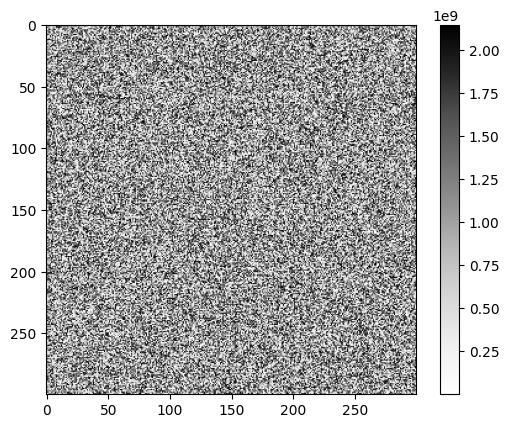

In [94]:
plt.imshow(pixels, cmap='Greys')
plt.colorbar()

## Uniformity

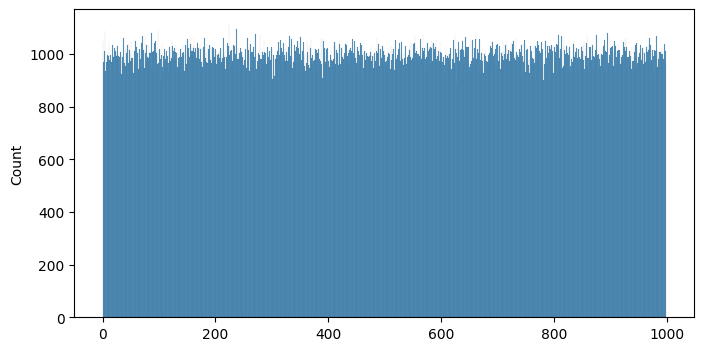

Chi-square statistic: 1057.2540000000001
p-value: 0.09790331260608465  (> 0.05 is good enough for this)


In [38]:
N_SAMPLES = 1_000_000
N_BINS = 1_000

hashes = np.array([my_hash(i) for i in range(N_SAMPLES)])
buckets = hashes % N_BINS

plt.figure(figsize=(8, 4))
sns.histplot(buckets, bins=N_BINS, kde=False)
plt.show()

# Chi-square test
expected = N_SAMPLES / N_BINS
observed, _ = np.histogram(buckets, bins=N_BINS)
chi2_stat, p_value = stats.chisquare(observed, expected)

print(f"Chi-square statistic: {chi2_stat}")
print(f"p-value: {p_value}  (> 0.05 is good enough for this)")

## Avalanche effect

average fraction of bits flipped: 0.5000


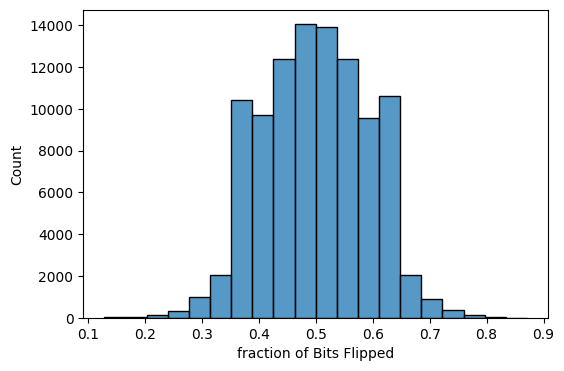

In [46]:
N_RUNS = 100_000
N_BITS = 31


bit_flips = []

for _ in range(N_RUNS):
    num = random.randint(0, 2**N_BITS - 1)
    bit_to_flip = 1 << random.randint(0, N_BITS - 1)
    num_flipped = num ^ bit_to_flip

    h1 = my_hash(num)
    h2 = my_hash(num_flipped)

    diff = bin(h1 ^ h2).count("1")
    bit_flips.append(diff / N_BITS)

mean_flip = np.mean(bit_flips)
print(f"average fraction of bits flipped: {mean_flip:.4f}")

plt.figure(figsize=(6, 4))
sns.histplot(bit_flips, bins=20)
plt.xlabel("fraction of Bits Flipped")
plt.show()


# Pseudorandom number generator

Let us use the above hash function to generate pseudorandom numbers.

In [70]:
class Random:
    MAX = 2**31 - 1
    
    def __init__(self, seed=None):
        if seed is None:
            seed = time.time_ns()
        self.seed = seed
        self.current_seed = seed
    
    def randrange(self, upper: int) -> int:
        new_seed_value = my_hash(self.current_seed)
        to_ret = new_seed_value % upper
        self.current_seed = new_seed_value
        return to_ret
    
    def random(self) -> float:
        new_seed_value = my_hash(self.current_seed)
        to_ret = new_seed_value / self.MAX
        self.current_seed = new_seed_value
        return to_ret


Visually

In [71]:
rnd = Random()
randoms = [rnd.randrange(1000) for _ in range(1000000)]

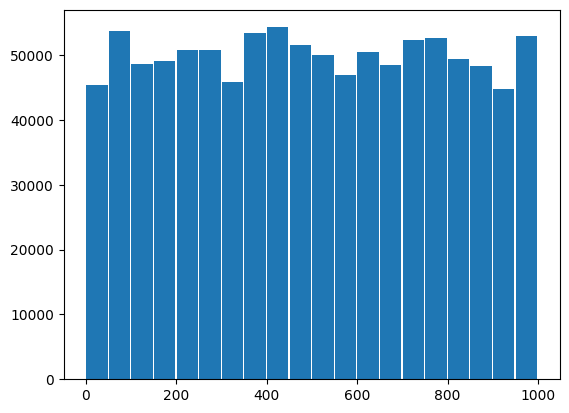

In [72]:
_ = plt.hist(randoms, bins=20, rwidth=0.95)

## Test the uniformity ($\chi^2$ test)

In [ ]:

rng = Random(seed=42)
N = 10_000
BINS = 10

samples = [rng.random() for _ in range(N)]
hist, _ = np.histogram(samples, bins=BINS, range=(0, 1))
expected = [N / BINS] * BINS

chi2_stat, p_value = stats.chisquare(hist, expected)
print(f"Chi^2: {chi2_stat}, p-value: {p_value} (good if > 0.05)")


Chi^2: 12.126, p-value: 0.20629889322492026 (good if > 0.05)


## Cycle length

A (pseudo-)random number generator is bad if it has a short cycle length. Let us estimate the average cycle length of the above generator.

In [100]:
def calc_cycle_length(randrange_func: Callable[[int], int]) -> int:
    seen = set()
    while True:
        val = randrange_func(Random.MAX)
        if val in seen:
            return len(seen)
        seen.add(val)

In [97]:
cycle_lengths = [calc_cycle_length(Random(i).randrange) for i in range(10_000)]

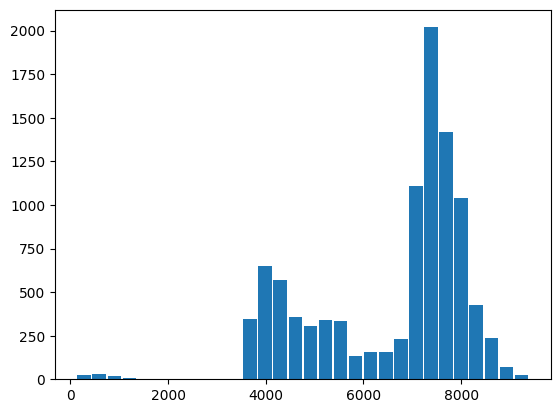

In [98]:
plt.hist(cycle_lengths, bins=30, rwidth=0.9)
plt.show()

Let's compare it with the built-in `random.randrange` for the same range.

In [101]:
cycle_lengths_python_rng = [calc_cycle_length(random.randrange) for i in range(10_000)]


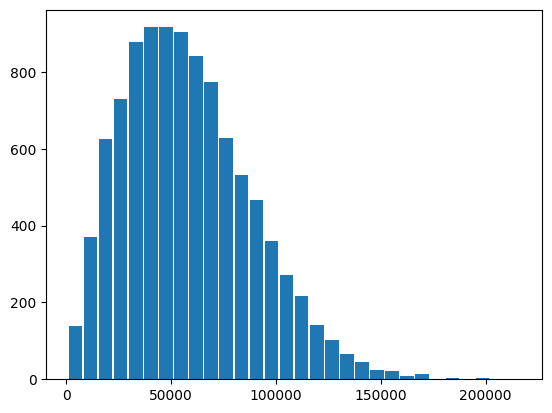

In [102]:
plt.hist(cycle_lengths_python_rng, bins=30, rwidth=0.9)
plt.show()

Clearly, my RNG sucks

## Monte Carlo for $\pi$

In [55]:
N = 10000000
ns = 0
for _ in range(N):
    r1 = rnd.random()
    r2 = rnd.random()
    if r1**2 + r2**2 < 1.0:
        ns += 1

In [58]:
f"pi = {4 * ns / N} ({abs(np.pi - 4 * ns / N) / np.pi:.4%} off)"

'pi = 3.0676824 (2.3526% off)'